In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [2]:
using ReactiveMP, KernelFunctions, Distributions, LinearAlgebra,GraphPPL, Rocket,Plots
using StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp
include("utils.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [3]:
xmin, xmax = -6, 6  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin - 0.1, xmax + 0.1; length=300));
kernelfunc =  Matern52Kernel()
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) 
ytrain     = rand(MvNormal(zeros(length(xtrain)),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

In [4]:
@model function gpclassification(n,kernelfunc,meanfunc,train,test)
    y = datavar(Float64,n)
    meta = ProcessMeta(nothing,kernelmatrix(kernelfunc,xtrain,xtrain),kernelmatrix(kernelfunc,xtest,xtest),kernelmatrix(kernelfunc,xtest,xtrain))
    x = randomprocess(test,train,meta)
    x ~ GaussianProcess(meanfunc,kernelfunc) 
    for i=1:n 
        y[i] ~ Probit(x) where {meta = (ProbitMeta(32),ProcessMeta(i,meta.Kxx,meta.Kff,meta.Kfx))}
    end
end

In [8]:
#Ismail's code
# @model function gpclassification(n,kernelfunc,meanfunc,train,test)
#     y = datavar(Float64,n)
#     x = randomprocess(test,train)
#     x ~ GaussianProcess(meanfunc,kernelfunc) 
#     for i=1:n 
#         y[i] ~ Probit(x) where {meta = (ProbitMeta(32),ProcessMeta(i,nothing,nothing,nothing))}
#     end
# end

In [5]:
@average_energy GaussianProcess (q_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any) = begin
    q_out.finitemarginal
    return -entropy(q_out.finitemarginal)
end

In [6]:
@rule Probit(:in, MomentMatching) (q_out::PointMass, m_in::GaussianProcess, meta::Tuple{ProbitMeta, ProcessMeta}) = begin 
    return @call_rule Probit(:in, MomentMatching) (m_out = q_out, m_in = m_in,meta=meta)
end

@rule Probit(:in, MomentMatching) (m_out::Union{PointMass, Bernoulli}, m_in::GaussianProcess,meta::Tuple{ProbitMeta,ProcessMeta}) =
    begin
    
        m_right, cov_right = mean_cov(m_in.finitemarginal)
        kernelf = m_in.kernelfunction
        meanf   = m_in.meanfunction
        test    = m_in.testinput
        train   = m_in.traininput
        mz, vz = predMVN(m_in,test,[train[meta[2].index]],m_right)
        mz = mz[1]
        vz = vz[1]
        # extract parameters
        p = mean(m_out)
        @assert p >= zero(p) && p <= one(p) "The Probit node only accepts messages on its output with values between 0 and 1."

        # calculate auxiliary variables
        γ = mz / sqrt(1 + vz)

        # calculate moments of g
        if γ > 0 && p > 0.5
            log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogccdf(-γ)))
        elseif γ <= 0 && p > 0.5
            log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogcdf(γ)))
        elseif γ > 0 && p <= 0.5
            log_mom0_pz = logsumexp((log(1 - p) + normlogcdf(-γ), log(p) + normlogcdf(γ)))
        else
            log_mom0_pz = logsumexp((log(1 - p) + normlogccdf(γ), log(p) + normlogcdf(γ)))
        end
        tmp = log(vz) + normlogpdf(γ) - log(1 + vz) / 2 - log_mom0_pz
        mom1_pz = mz + (2 * p - 1) * exp(tmp)
        mom2_pz = vz + mz^2 + (2 * p - 1) * 2 * mz * exp(tmp) - (2p - 1) * γ * exp(log(vz) - log(1 + vz) / 2 + tmp)

        # calculate parameters of posterior
        mpz = mom1_pz
        vpz = mom2_pz - mom1_pz^2
        vpz = clamp(vpz, tiny, vz)# ensure variance of marginal is not larger than the variance of the cavity distribution.

        # calculate parameters of outgoing message
        wz_out = clamp(1 / vpz - 1 / vz, tiny, huge) # Ensure precision isn't too small or too large
        ξz_out = mpz / vpz - mz / vz

        # return message
        return NormalWeightedMeanPrecision(ξz_out, wz_out)
end

### rule just added 
@rule Probit(:in, MomentMatching) (q_out::PointMass, m_in::UnivariateNormalDistributionsFamily, meta::Tuple{ProbitMeta, ProcessMeta}) = begin 
    # extract parameters
    mz, vz = mean_cov(m_in)
    p = mean(q_out)
    @assert p >= zero(p) && p <= one(p) "The Probit node only accepts messages on its output with values between 0 and 1."

    # calculate auxiliary variables
    γ = mz / sqrt(1 + vz)

    # calculate moments of g
    if γ > 0 && p > 0.5
        log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogccdf(-γ)))
    elseif γ <= 0 && p > 0.5
        log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogcdf(γ)))
    elseif γ > 0 && p <= 0.5
        log_mom0_pz = logsumexp((log(1 - p) + normlogcdf(-γ), log(p) + normlogcdf(γ)))
    else
        log_mom0_pz = logsumexp((log(1 - p) + normlogccdf(γ), log(p) + normlogcdf(γ)))
    end
    tmp = log(vz) + normlogpdf(γ) - log(1 + vz) / 2 - log_mom0_pz
    mom1_pz = mz + (2 * p - 1) * exp(tmp)
    mom2_pz = vz + mz^2 + (2 * p - 1) * 2 * mz * exp(tmp) - (2p - 1) * γ * exp(log(vz) - log(1 + vz) / 2 + tmp)

    # calculate parameters of posterior
    mpz = mom1_pz
    vpz = mom2_pz - mom1_pz^2
    vpz = clamp(vpz, tiny, vz)# ensure variance of marginal is not larger than the variance of the cavity distribution.

    # calculate parameters of outgoing message
    wz_out = clamp(1 / vpz - 1 / vz, tiny, huge) # Ensure precision isn't too small or too large
    ξz_out = mpz / vpz - mz / vz

    # return message
    return NormalWeightedMeanPrecision(ξz_out, wz_out)
end
###############

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass) = begin 
    return GaussianProcess(q_meanfunc.point,q_kernelfunc.point,nothing,nothing,nothing,nothing)
end

function ReactiveMP.marginal_prod_fn(process::RandomProcess)
    test  = process.test_input
    train = process.train_input
    ####
    meta = process.meta
    ####
    return messages -> begin 
        message_vector = map(ReactiveMP.as_message, messages)
        process_message = getdata(message_vector[1])
        meanf = process_message.meanfunction
        kernelf = process_message.kernelfunction
        likelihood_messages = message_vector[2:end]
        m_right,cov_right = make_multivariate_message(likelihood_messages)

        #m, K = predMVN(kernelf,meanf,train,test,m_right,cov_right)
        m, K = predMVN(meta,process_message,train,test,m_right,cov_right)
        invKff = cholinv(meta.Kff + K)
        return Marginal(GaussianProcess(meanf,kernelf,MvNormalMeanCovariance(m,K),test,train,invKff),false,false)
    
    end
end

function ReactiveMP.messages_prod_fn(process::RandomProcess)
    return messages -> begin
        marginal = Rocket.getrecent(process.marginal.subject)
        if marginal == nothing
#             @show "here"
            return Message(NormalMeanVariance(0.0,0.01),false,false)
        else
#             @show "here2"
            marginal = ReactiveMP.getdata(Rocket.getrecent(process.marginal.subject))
            return Message(marginal,false,false)
        end
        
    end
end

In [7]:
nits = 1


iresult = inference(
    model = Model(gpclassification, N, kernelfunc, meanfunc, xtrain,xtest),
    iterations = nits,  
    data  = (y = ytrainbin,),
    showprogress= true,
    free_energy = true
    
)

Inference results:
-----------------------------------------
Free Energy: Real[]
-----------------------------------------
x = GaussianProcess[GaussianProcess(var"#11#12"(), Matern 5/2 Kernel (metric = Dista...


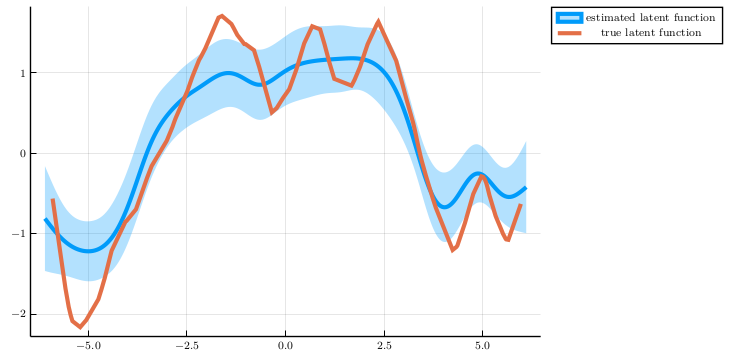

In [12]:
# Hoang's Plot 
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal), ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3,fillalpha=0.3,label="estimated latent function")
plot!(xtrain,ytrain,linewidth=3.0,label="true latent function")


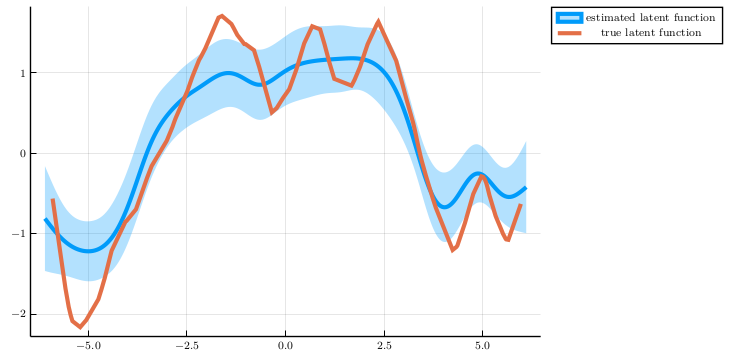

In [16]:

plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal), ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3,fillalpha=0.3,label="estimated latent function")
plot!(xtrain,ytrain,linewidth=3.0,label="true latent function")


In [13]:
function class_probabilities(gp)
    marginal = gp.finitemarginal
    m = mean(marginal)
    s =  sqrt.(1 .+ diag(cov(iresult.posteriors[:x][end].finitemarginal)))
    return normcdf.( m ./ s)
    
end

function class_predict(gp)
    
    return map(rand,Bernoulli.(class_probabilities(gp)))
end

class_predict (generic function with 1 method)

In [14]:
class_probs = class_probabilities(iresult.posteriors[:x][end]);
class_dist  = Bernoulli.(class_probs);
predicted_class = class_predict(iresult.posteriors[:x][end]);

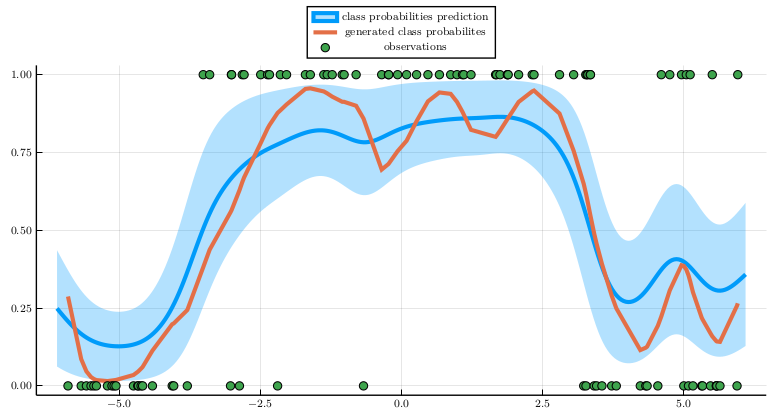

In [15]:
#Hoang's plot 
plot(xtest,mean.(class_dist),ribbon=(var.(class_dist)),fillalpha=0.3,linewidth=3.0, label="class probabilities prediction")
plot!(xtrain,p,linewidth=3.0,label="generated class probabilites")
scatter!(xtrain,ytrainbin,legend=:outertop,size=(800,400),label="observations")

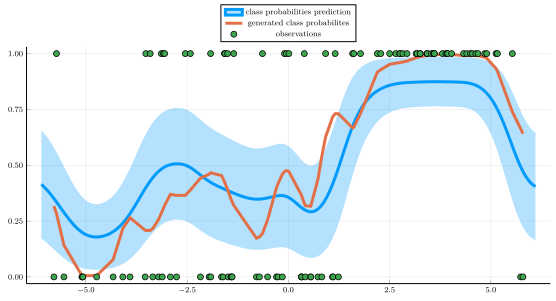

In [204]:
plot(xtest,mean.(class_dist),ribbon=(var.(class_dist)),fillalpha=0.3,linewidth=3.0, label="class probabilities prediction")
plot!(xtrain,p,linewidth=3.0,label="generated class probabilites")
scatter!(xtrain,ytrainbin,legend=:outertop,size=(800,400),label="observations")

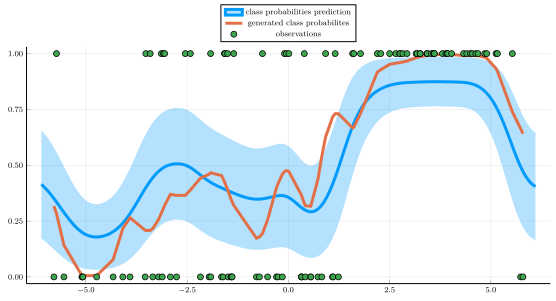

In [205]:
plot(xtest,mean.(class_dist),ribbon=(var.(class_dist)),fillalpha=0.3,linewidth=3.0, label="class probabilities prediction")
plot!(xtrain,p,linewidth=3.0,label="generated class probabilites")
scatter!(xtrain,ytrainbin,legend=:outertop,size=(800,400),label="observations")